In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ["WANDB_API_KEY"] = "cd71d6f2249981dffae87be7baa57f08fe64c95e"
os.environ["WANDB_MODE"] = "online"
wandb.login()

wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(
    project="driver-drowsiness",
    name="mobilenetv2_transfer2",
    config={
        "img_size": 224,                 # REQUIRED for pretrained
        "batch_size": 32,
        "epochs": 15,                    # stage 1
        "optimizer": "Adam",
        "architecture": "MobileNetV2",
        "learning_rate": 1e-5,
        "loss": "binary_crossentropy",
        "stage": "feature_extraction"
    }
)

config = wandb.config


In [4]:
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25, 
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    "../data/train",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    "../data/val",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "../data/test",
    target_size=(config.img_size, config.img_size),
    batch_size=config.batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)


Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


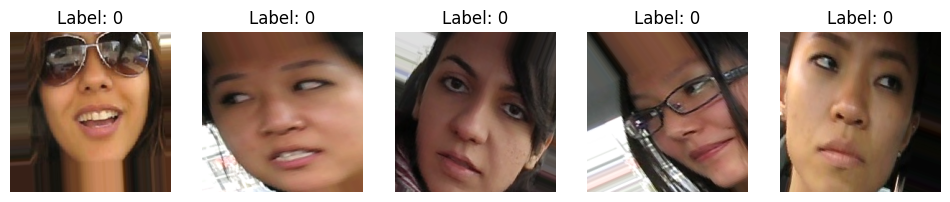

In [5]:
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))

for i in range(5):
    img = x_batch[i]

    # Reverse preprocess_input FOR VISUALIZATION ONLY
    img_vis = (img + 1.0) / 2.0        # [-1,1] -> [0,1]
    img_vis = np.clip(img_vis, 0, 1)

    axes[i].imshow(img_vis)
    axes[i].set_title(f"Label: {int(y_batch[i])}")
    axes[i].axis("off")

plt.show()


In [6]:
print(train_generator.class_indices)

{'normal': 0, 'yawn': 1}


In [7]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(config.img_size, config.img_size, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=config.loss,
    metrics=["accuracy"]
)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,370,177 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

checkpoint = WandbModelCheckpoint(
    filepath="../models/mobilenet2/best.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
)

callbacks = [
    early_stop,
    checkpoint,
    reduce_lr,
    WandbMetricsLogger()
]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [11]:
weights = {0: 1.0, 1: 2.85}
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.epochs,
    class_weight=weights,
    callbacks=callbacks,
)


Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5334 - loss: 1.1439 - val_accuracy: 0.6444 - val_loss: 0.6385 - learning_rate: 1.0000e-05
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.5585 - loss: 1.0485 - val_accuracy: 0.6617 - val_loss: 0.6079 - learning_rate: 1.0000e-05
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6124 - loss: 0.9502 - val_accuracy: 0.7877 - val_loss: 0.5323 - learning_rate: 1.0000e-05
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6738 - loss: 0.9377 - val_accuracy: 0.8469 - val_loss: 0.4703 - learning_rate: 1.0000e-05
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.7007 - loss: 0.8330 - val_accuracy: 0.8790 - val_loss: 0.4349 - learning_rate: 1.0000e-05
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7046 - loss: 0.8128 - val_accuracy: 0.8889 - val_loss: 0.4132 - learning_rate: 1.0000e-05
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7967 

In [22]:
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()
y_true = test_generator.classes

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 925ms/step


In [23]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)   # THIS IS CRITICAL
f1 = f1_score(y_true, y_pred)
print(f"accuracy_score:{acc}\nprecision_score:{prec}\nrecall_score:{rec}\nf1_score:{f1}")

accuracy_score:0.8968058968058968
precision_score:0.8148148148148148
recall_score:0.8
f1_score:0.8073394495412844


In [14]:
wandb.log({
    "test_accuracy": acc,
    "test_precision": prec,
    "test_recall": rec,
    "test_f1": f1
})

In [15]:
class_names = list(test_generator.class_indices.keys())
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
)

print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      normal     0.9264    0.9327    0.9295       297
        yawn     0.8148    0.8000    0.8073       110

    accuracy                         0.8968       407
   macro avg     0.8706    0.8663    0.8684       407
weighted avg     0.8963    0.8968    0.8965       407



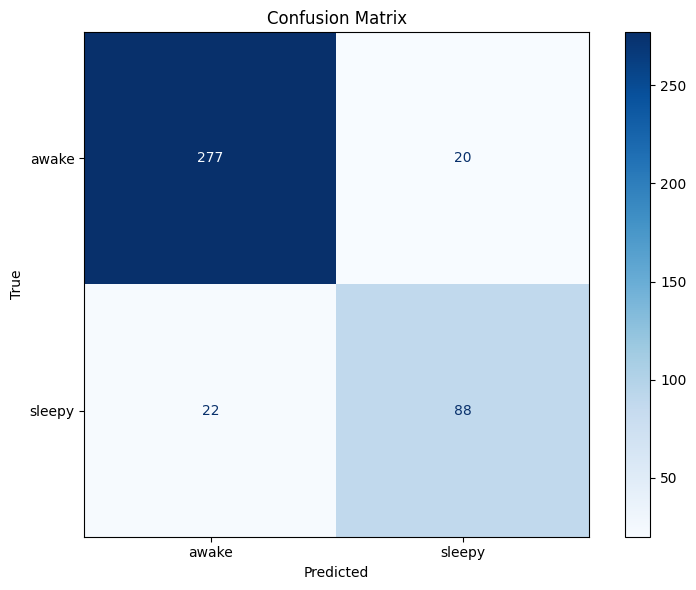

In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(cm, display_labels=['awake','sleepy'])
cmd.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
with open("../models/mobilenet2/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [19]:
wandb.finish()

epoch/accuracy,▁▂▃▄▅▅▆▇▇▇████▇
epoch/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▃▂▂▁▂▁▁▁
epoch/val_accuracy,▁▁▅▆▇▇█████████
epoch/val_loss,█▇▆▅▄▄▃▃▂▂▂▁▁▁▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
epoch/accuracy,0.82857
